### Movie Recommender System

The goal of this exercise is to develop a recommender system for movies. 

https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system

We will explore different recommendation techniques for building our recommendation systems

<div>
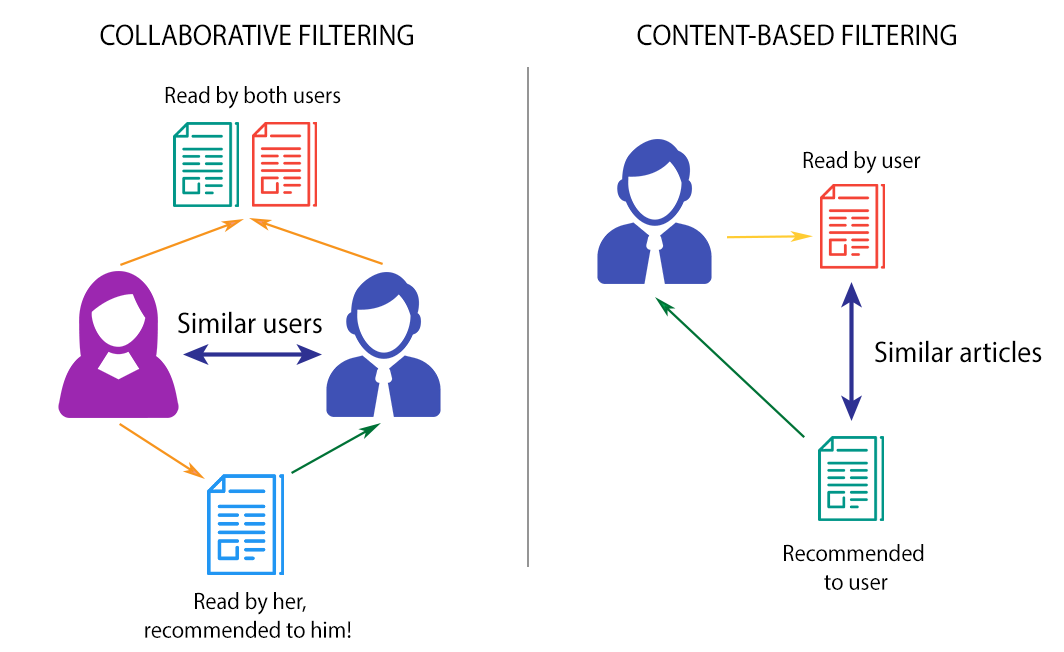
</div>

Content Based Filtering:
Here we make use of user level information such as geners, plot, director, cast etc to make recommendations. Since it is directly uses the contents of one movie to generate a recommendation set, it is called as content based recommendation.

Collaborative Filtering:
In Collaborative Filtering, we make use of movie viewers vs movie titles utility matrix, with movie ratings as the values. We create a 2-D utility matrix containing movie viewers on one dimension and movie titles on the other. We find similarity between the viewers and movies and recommend movies based on the similarity. This is a type of neighborhood based recommender.


### About the data

The movies dataset is available for download on Kaggle website @ https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset

credits.csv - This includes details on cast, crew

keywords.csv - Keywords associated with the movies

links.csv - This dataset matches the keys between movie id, IMDB id and TMDB ID

links_small.csv - A smaller data set of the links.csv file. This dataset matches the keys between movie id, IMDB id and TMDB ID

movies_metadata.csv - This consists of dat on movies details such as year, movie collections, genre, title, budget, revenue, popularity rations, view counts, average ratings etc

ratings_small.csv - This contains viwers id, their ratings of movies


### Libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate,train_test_split

import warnings; warnings.simplefilter('ignore')

pd.options.display.max_colwidth = 50

In [2]:
!pwd

/home/jupyter/recommendation_systems/movie_recommender


In [3]:
#read movie data
df_movies_metadata=pd. read_csv('/home/jupyter/recommendation_systems/movie_recommender/input/movies_metadata.csv')

In [4]:
df_credits = pd.read_csv('/home/jupyter/recommendation_systems/movie_recommender/input/credits.csv')
df_keywords = pd.read_csv('/home/jupyter/recommendation_systems/movie_recommender/input/keywords.csv')

In [5]:
df_keywords['id'] = df_keywords['id'].astype('int')
df_credits['id'] = df_credits['id'].astype('int')
df_movies_metadata = df_movies_metadata[~df_movies_metadata['id'].str.contains('-')]
df_movies_metadata['id'] = df_movies_metadata['id'].astype('int')

In [6]:
df_movies_metadata = df_movies_metadata.merge(df_credits, on='id')
df_movies_metadata = df_movies_metadata.merge(df_keywords, on='id')

In [7]:
df_movies_metadata.head(1)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew,keywords
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."


In [8]:
df_movies_metadata.shape

(46628, 27)

In [9]:
df_movies_metadata['year'] = pd.to_datetime(df_movies_metadata['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

### Recommendation based on IMDB Rating

Below we shall develop a popularity based recommender which can be used to display in the trending section of the "Netflix" like website.

The formula for calculating the weighted average rating is given as:

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C where:

R = average for the movie (mean) = (Rating)\
v = number of votes for the movie = (votes)\
m = minimum votes required to be listed in the Top 250\
C = the mean vote across the whole report

We already have v(vote_count) and R (vote_average) and C can be calculated as

In [10]:
df_movies_metadata['genres1'] = [[genres_item['name'] for genres_item in literal_eval(genres_list)] for genres_list in df_movies_metadata["genres"]]

In [11]:
df_movies_metadata['genres1'].head()

0     [Animation, Comedy, Family]
1    [Adventure, Fantasy, Family]
2               [Romance, Comedy]
3        [Comedy, Drama, Romance]
4                        [Comedy]
Name: genres1, dtype: object

<AxesSubplot:ylabel='Frequency'>

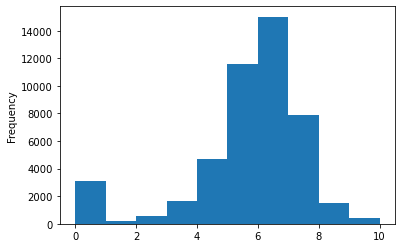

In [12]:
#Here is the count histogram of the average ratings
df_movies_metadata['vote_average'].plot.hist()

In [13]:
#Mean rating C is calculated as
# C= df_movies_metadata['vote_average'].mean()
# C

vote_counts = df_movies_metadata[df_movies_metadata['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = df_movies_metadata[df_movies_metadata['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.238696808510638

The mean rating for all the movies is approx 6 on a scale of 10. 

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 90th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 90% of the movies in the list.

In [14]:
#We will chose 90th quantile which gives the minimum number of votes of 1838 to make it into the top charts
m = df_movies_metadata['vote_count'].quantile(.9)
print("minimum votes required to be listed in the Top 250 ",m)
top_chart_movies = df_movies_metadata[((df_movies_metadata['vote_count']) >= m) & (df_movies_metadata['vote_count'].notnull()) & (df_movies_metadata['vote_average'].notnull()) ]
top_chart_movies.shape

minimum votes required to be listed in the Top 250  156.0


(4680, 29)

In [15]:
#Function for scoring the weighted rating
def weighted_rating(df):
    v = df['vote_count']
    R = df['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [16]:
top_chart_movies['wt_ratings'] = round(top_chart_movies.apply(weighted_rating, axis=1),1)

In [17]:
#Sort movies based on score calculated above
top_chart_movies = top_chart_movies.sort_values('wt_ratings', ascending=False)

#Print the top 15 movies
top_chart_movies[['title', 'vote_count', 'vote_average','popularity','genres1','wt_ratings']].head(10)

,title,vote_count,vote_average,popularity,genres1,wt_ratings
10397,Dilwale Dulhania Le Jayenge,661.0,9.1,34.457024,"[Comedy, Drama, Romance]",8.4
841,The Godfather,6024.0,8.5,41.109264,"[Drama, Crime]",8.4
314,The Shawshank Redemption,8358.0,8.5,51.645403,"[Drama, Crime]",8.4
12589,The Dark Knight,12269.0,8.3,123.167259,"[Drama, Action, Crime, Thriller]",8.3
2870,Fight Club,9678.0,8.3,63.869599,[Drama],8.3
292,Pulp Fiction,8670.0,8.3,140.950236,"[Thriller, Crime]",8.2
2231,Life Is Beautiful,3643.0,8.3,39.39497,"[Comedy, Drama]",8.2
1199,The Godfather: Part II,3418.0,8.3,36.629307,"[Drama, Crime]",8.2
5529,Spirited Away,3968.0,8.3,41.048867,"[Fantasy, Adventure, Animation, Family]",8.2
23868,Whiplash,4376.0,8.3,64.29999,[Drama],8.2


Now we can display the above list in the trending section. This is a very basic recommender. Now it is time to add more complexity and personalization.

### Top charts by genres

Now we create top charts based on genres such as action, romance, thriller etc

In [18]:
def top_charts_by_genres(genre = 'Action', percentile=0.85):
    df = df_movies_metadata[df_movies_metadata['genres'].str.contains(genre)]
    #Mean rating C is calculated as
    C= df['vote_average'].mean()
    m = df_movies_metadata['vote_count'].quantile(percentile)

    df1 = df[df['vote_count'] >= m]
    
    df1['wt_ratings'] = round(df1.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) \
                                                  + (m/(m+x['vote_count']) * C), axis=1),1)
    df1 = df1[['title','year', 'vote_count', 'vote_average','popularity','genres1','wt_ratings']].sort_values('wt_ratings', ascending=False).head(250)
    return df1    

In [19]:
top_charts_by_genres('Fantasy').head(10)

,title,year,vote_count,vote_average,popularity,genres1,wt_ratings
3057,The Green Mile,1999,4166.0,8.2,19.96678,"[Fantasy, Drama, Crime]",8.2
5529,Spirited Away,2001,3968.0,8.3,41.048867,"[Fantasy, Adventure, Animation, Family]",8.2
2911,Princess Mononoke,1997,2041.0,8.2,17.166725,"[Adventure, Fantasy, Animation]",8.1
9786,Howl's Moving Castle,2004,2049.0,8.2,16.136048,"[Fantasy, Animation, Adventure]",8.1
7069,The Lord of the Rings: The Return of the King,2003,8226.0,8.1,29.324358,"[Adventure, Fantasy, Action]",8.1
4904,The Lord of the Rings: The Fellowship of the Ring,2001,8892.0,8.0,32.070725,"[Adventure, Fantasy, Action]",8.0
5876,The Lord of the Rings: The Two Towers,2002,7641.0,8.0,29.423537,"[Adventure, Fantasy, Action]",8.0
5895,My Neighbor Totoro,1988,1730.0,8.0,13.507299,"[Fantasy, Animation, Family]",7.9
17627,Harry Potter and the Deathly Hallows: Part 2,2011,6141.0,7.9,24.990737,"[Family, Fantasy, Adventure]",7.9
2603,The Legend of 1900,1998,554.0,8.1,7.668214,[Fantasy],7.8


Now that we have built a sligthly more specific recommender based on genre, we can extend this to build other types of demography based recommender based on age, gender etc.

### Content Based Filtering Recommender

In [20]:
# Concatenate Overview with Tagline to get a better plot.

df_movies_metadata['plot'] = df_movies_metadata['tagline']+' '+df_movies_metadata['overview']
df_movies_metadata['plot'] = df_movies_metadata['plot'].fillna('')
df_movies_metadata['plot'].head()

0                                                     
1    Roll the dice and unleash the excitement! When...
2    Still Yelling. Still Fighting. Still Ready for...
3    Friends are the people who let you be yourself...
4    Just When His World Is Back To Normal... He's ...
Name: plot, dtype: object

We shall use **TF-IDF**, (term frequency–inverse document frequency) to convert the overview to a number, **TF-IDF** is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. 

Term Frequency - There are several ways of calculating this frequency, but here is use the formula # of times the term occurs in the plot of a movie / (divided by) total # of times it occurs across plot of all the movies
Inverse Document Frequency - log(number of movies/plot with term)

TF-IDF = TF * IDF. This gives the overall importance of the term.

We will first clean the plots of stop words (commonly occuring words such as 'a', 'the', 'at' etc) so that we are left with important words.

In [21]:

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0,stop_words='english')

#Replace NaN with an empty string
df_movies_metadata['plot'] = df_movies_metadata['plot'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_movies_metadata['plot'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(46628, 572966)

There are many methods to find similarities between two vectors such as Cosine similarity, Pearson Coefficient, Euclidean Distance, Jaccard Distance. Here we will calculate the cosine similarity. It is defined as follows:

$cosine(X,Y)=\frac{X.Y^T}{||X||.||Y||}\$

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [22]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [23]:
df_movies_metadata['id'].head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: id, dtype: int64

In [24]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df_movies_metadata.index, index=df_movies_metadata['title']).drop_duplicates()

indices['The Dark Knight Rises']

18442

In [25]:
df_movies_metadata[df_movies_metadata['title'] == 'The Dark Knight Rises']

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,title,video,vote_average,vote_count,cast,crew,keywords,year,genres1,plot
18442,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",http://www.thedarkknightrises.com/,49026,tt1345836,en,The Dark Knight Rises,Following the death of District Attorney Harve...,...,The Dark Knight Rises,False,7.6,9263.0,"[{'cast_id': 2, 'character': 'Bruce Wayne / Ba...","[{'credit_id': '52fe4781c3a36847f81398c3', 'de...","[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",2012,"[Action, Crime, Drama, Thriller]",The Legend Ends Following the death of Distric...


In [26]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df_movies_metadata[feature] = df_movies_metadata[feature].apply(literal_eval)
    
df_movies_metadata['cast'].head()

0    [{'cast_id': 14, 'character': 'Woody (voice)',...
1    [{'cast_id': 1, 'character': 'Alan Parrish', '...
2    [{'cast_id': 2, 'character': 'Max Goldman', 'c...
3    [{'cast_id': 1, 'character': 'Savannah 'Vannah...
4    [{'cast_id': 1, 'character': 'George Banks', '...
Name: cast, dtype: object

In [27]:
#get_director
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

df_movies_metadata['director'] = df_movies_metadata['crew'].apply(get_director)
df_movies_metadata['director'].head()

0      John Lasseter
1       Joe Johnston
2      Howard Deutch
3    Forest Whitaker
4      Charles Shyer
Name: director, dtype: object

In [28]:
df_movies_metadata['top3_actors'] = df_movies_metadata['cast'].apply(lambda x: [i['name'] for i in x])
df_movies_metadata['top3_actors'] = df_movies_metadata['top3_actors'].apply(lambda x: x[:3] if len(x) > 3 else x)
df_movies_metadata['top3_actors'].head()

0                  [Tom Hanks, Tim Allen, Don Rickles]
1       [Robin Williams, Jonathan Hyde, Kirsten Dunst]
2           [Walter Matthau, Jack Lemmon, Ann-Margret]
3    [Whitney Houston, Angela Bassett, Loretta Devine]
4           [Steve Martin, Diane Keaton, Martin Short]
Name: top3_actors, dtype: object

In [29]:
df_movies_metadata['genres1'] = df_movies_metadata['genres1'].apply(lambda x: x[:3] if len(x) >3 else x)

In [66]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # If multiple movies have the same title, get the most recent movie's index
    idx= df_movies_metadata[df_movies_metadata['title'] == title].sort_values(by='popularity', ascending=False).index[0]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df_movies_metadata[['title','year','director','top3_actors','genres1']].iloc[movie_indices]

In [67]:
#Top 10 movies similar to the movie - The Dark Knight Rises
get_recommendations('Batman')

,title,year,director,top3_actors,genres1
9312,Batman Beyond: Return of the Joker,2000,Curt Geda,"[Will Friedle, Kevin Conroy, Mark Hamill]","[Animation, Family]"
21599,Batman: Mystery of the Batwoman,2003,Curt Geda,"[Kevin Conroy, Tara Strong, Héctor Elizondo]","[Adventure, Fantasy, Animation]"
3122,Batman: Mask of the Phantasm,1993,Bruce Timm,"[Kevin Conroy, Mark Hamill, Dana Delany]","[Action, Adventure, Animation]"
25468,Batman vs Dracula,2005,Michael Goguen,"[Rino Romano, Peter Stormare, Tara Strong]","[Fantasy, Animation, Horror]"
18442,The Dark Knight Rises,2012,Christopher Nolan,"[Christian Bale, Michael Caine, Gary Oldman]","[Action, Crime, Drama]"
150,Batman Forever,1995,Joel Schumacher,"[Val Kilmer, Tommy Lee Jones, Jim Carrey]","[Action, Crime, Fantasy]"
32329,Batman Unlimited: Monster Mayhem,2015,Butch Lukic,"[Roger Craig Smith, Troy Baker, Chris Diamanto...","[Action, Animation, Family]"
15682,Batman: Under the Red Hood,2010,Brandon Vietti,"[Bruce Greenwood, Jensen Ackles, Neil Patrick ...","[Action, Animation]"
10210,Batman Begins,2005,Christopher Nolan,"[Christian Bale, Michael Caine, Liam Neeson]","[Action, Crime, Drama]"
12589,The Dark Knight,2008,Christopher Nolan,"[Christian Bale, Michael Caine, Heath Ledger]","[Drama, Action, Crime]"


In [32]:
#Top 10 movies similar to the movie - Scarface
get_recommendations('The Dark Knight Rises')

,title,year,director,top3_actors,genres1
150,Batman Forever,1995,Joel Schumacher,"[Val Kilmer, Tommy Lee Jones, Jim Carrey]","[Action, Crime, Fantasy]"
12589,The Dark Knight,2008,Christopher Nolan,"[Christian Bale, Michael Caine, Heath Ledger]","[Drama, Action, Crime]"
3122,Batman: Mask of the Phantasm,1993,Bruce Timm,"[Kevin Conroy, Mark Hamill, Dana Delany]","[Action, Adventure, Animation]"
1349,Batman Returns,1992,Tim Burton,"[Michael Keaton, Danny DeVito, Michelle Pfeiffer]","[Action, Fantasy]"
585,Batman,1989,Tim Burton,"[Jack Nicholson, Michael Keaton, Kim Basinger]","[Fantasy, Action]"
21599,Batman: Mystery of the Batwoman,2003,Curt Geda,"[Kevin Conroy, Tara Strong, Héctor Elizondo]","[Adventure, Fantasy, Animation]"
15682,Batman: Under the Red Hood,2010,Brandon Vietti,"[Bruce Greenwood, Jensen Ackles, Neil Patrick ...","[Action, Animation]"
9312,Batman Beyond: Return of the Joker,2000,Curt Geda,"[Will Friedle, Kevin Conroy, Mark Hamill]","[Animation, Family]"
18225,Batman: Year One,2011,Lauren Montgomery,"[Ben McKenzie, Bryan Cranston, Eliza Dushku]","[Action, Adventure, Animation]"
25468,Batman vs Dracula,2005,Michael Goguen,"[Rino Romano, Peter Stormare, Tara Strong]","[Fantasy, Animation, Horror]"


### Metadata based recommender

In this section we will develop a recommender based on director, cast, genre and keywords given in the data

In [33]:
#get_director
# def get_top3_cast(x):
#     actor_list = [i['name'] for i in x]
#     if len(actor_list) > 3:
#         actor_list = actor_list[:3]
#     return actor_list

In [34]:
df_movies_metadata['keywords'].head()

0    [{'id': 931, 'name': 'jealousy'}, {'id': 4290,...
1    [{'id': 10090, 'name': 'board game'}, {'id': 1...
2    [{'id': 1495, 'name': 'fishing'}, {'id': 12392...
3    [{'id': 818, 'name': 'based on novel'}, {'id':...
4    [{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...
Name: keywords, dtype: object

In [35]:
#convert keywords to a list
df_movies_metadata['keywords'] = df_movies_metadata['keywords'].apply(lambda x: [i['name'] for i in x])

In [36]:
# Print the new features of the first 3 films
df_movies_metadata[['title', 'top3_actors', 'director', 'keywords', 'genres1']].head(3)

,title,top3_actors,director,keywords,genres1
0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter,"[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]"
1,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston,"[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch,"[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]"


Remove spaces between first and last names so that they are unique and the algorithm doesn't get misled into assuming two people starting with same first name but different last names are similar and related.

In [37]:
#remove space in names
df_movies_metadata['top3_actors1'] = df_movies_metadata['top3_actors'].apply(lambda x: [i.replace(" ",'') for i in x])
df_movies_metadata['director1'] = df_movies_metadata['director'].astype('str').apply(lambda x: x.replace(" ",''))

Let us weight Director more by repeating their names thrice

In [38]:
df_movies_metadata['director1'] = df_movies_metadata['director1'].apply(lambda x: [x,x,x])

df_movies_metadata['director1'].head(2)

0    [JohnLasseter, JohnLasseter, JohnLasseter]
1       [JoeJohnston, JoeJohnston, JoeJohnston]
Name: director1, dtype: object

Next step is to remove those words which occur only once in the keywords list as they are not predictive

In [39]:
keywords_list = df_movies_metadata.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
keywords_list.name = 'keywords'

In [40]:
keywords_list = keywords_list.value_counts()
keywords_list = keywords_list[keywords_list>1]
keywords_list

woman director      3128
independent film    1942
murder              1314
based on novel       841
musical              734
                    ... 
cheyenne               2
roller skating         2
garbage can            2
hearing voices         2
rhyme battle           2
Name: keywords, Length: 11397, dtype: int64

In [41]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

'dog'

In [42]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in keywords_list:
            words.append(i)
    return words

In [43]:
df_movies_metadata['keywords'] = df_movies_metadata['keywords'].apply(filter_keywords)
df_movies_metadata['keywords'] = df_movies_metadata['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])

In [44]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['top3_actors1']) + ' '.join(x['director1']) + ' ' + ' '.join(x['genres1'])
df_movies_metadata['soup'] = df_movies_metadata.apply(create_soup, axis=1)

We analyze the soup of words the same way we did with the plot earlier. We apply TFIDF transformation to quantify how important each word is across all the documents.

In [45]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0,stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_movies_metadata['soup'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

cosine_sim2 = linear_kernel(tfidf_matrix, tfidf_matrix)

In [46]:
#Top 10 movies similar to the movie - The Dark Knight Rises
get_recommendations('The Dark Knight Rises',cosine_sim2)

,title,year,director,top3_actors,genres1
12589,The Dark Knight,2008,Christopher Nolan,"[Christian Bale, Michael Caine, Heath Ledger]","[Drama, Action, Crime]"
10210,Batman Begins,2005,Christopher Nolan,"[Christian Bale, Michael Caine, Liam Neeson]","[Action, Crime, Drama]"
26110,Doodlebug,1997,Christopher Nolan,[Jeremy Theobald],"[Fantasy, Mystery]"
26111,Doodlebug,1997,Christopher Nolan,[Jeremy Theobald],"[Fantasy, Mystery]"
2486,Following,1998,Christopher Nolan,"[Jeremy Theobald, Alex Haw, Lucy Russell]","[Crime, Drama, Thriller]"
43147,DC Showcase: Catwoman,2011,Lauren Montgomery,"[Eliza Dushku, John DiMaggio, Liliana Mumy]","[Action, Adventure, Animation]"
1349,Batman Returns,1992,Tim Burton,"[Michael Keaton, Danny DeVito, Michelle Pfeiffer]","[Action, Fantasy]"
15651,Inception,2010,Christopher Nolan,"[Leonardo DiCaprio, Joseph Gordon-Levitt, Elle...","[Action, Thriller, Science Fiction]"
11463,The Prestige,2006,Christopher Nolan,"[Hugh Jackman, Christian Bale, Michael Caine]","[Drama, Mystery, Thriller]"
1511,Batman & Robin,1997,Joel Schumacher,"[George Clooney, Chris O'Donnell, Arnold Schwa...","[Action, Crime, Fantasy]"


Let's try using count vectorize instead of TFIDF and check our results

In [47]:
count = CountVectorizer(stop_words='english')

# count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(df_movies_metadata['soup'])

cosine_sim3 = cosine_similarity(count_matrix, count_matrix)

In [48]:
#Top 10 movies similar to the movie - The Dark Knight Rises
get_recommendations('The Dark Knight Rises',cosine_sim3)

,title,year,director,top3_actors,genres1
12589,The Dark Knight,2008,Christopher Nolan,"[Christian Bale, Michael Caine, Heath Ledger]","[Drama, Action, Crime]"
10210,Batman Begins,2005,Christopher Nolan,"[Christian Bale, Michael Caine, Liam Neeson]","[Action, Crime, Drama]"
2486,Following,1998,Christopher Nolan,"[Jeremy Theobald, Alex Haw, Lucy Russell]","[Crime, Drama, Thriller]"
1511,Batman & Robin,1997,Joel Schumacher,"[George Clooney, Chris O'Donnell, Arnold Schwa...","[Action, Crime, Fantasy]"
21616,Kick-Ass 2,2013,Jeff Wadlow,"[Aaron Taylor-Johnson, Chloë Grace Moretz, Chr...","[Action, Adventure, Crime]"
5094,Hero at Large,1980,Martin Davidson,"[John Ritter, Anne Archer, Bert Convy]","[Action, Comedy, Drama]"
9311,Shiner,2000,John Irvin,"[Michael Caine, Martin Landau, Andy Serkis]","[Drama, Action, Crime]"
15184,Defendor,2009,Peter Stebbings,"[Woody Harrelson, Kat Dennings, Elias Koteas]","[Drama, Action, Comedy]"
585,Batman,1989,Tim Burton,"[Jack Nicholson, Michael Keaton, Kim Basinger]","[Fantasy, Action]"
30753,Suicide Squad,2016,David Ayer,"[Will Smith, Margot Robbie, Joel Kinnaman]","[Action, Adventure, Crime]"


When we compare the results of TDIDF to that of the count vectors, we can see that the results presented by TDIDF gives better **"similar"** movies

### Collaborative Filtering

While, the above recommendation techniques are alright, they do not take into account the individual viewers choices and biases. Therefore, they are not good for personalization.

In collaborative filtering, we make use of viwers past ratings of the movies they have watched and recommend similar movies. If a viewer $X$ has not rated a particular movie yet, we find a look-alike users who have rated the said movie and make ratings predictions for the viewer $X$.

The utility matrix of vievwers vs movies containing ratings is created and utilized for making recommendations. We find similarity between users and similarities in movies to make predictions.
<div>
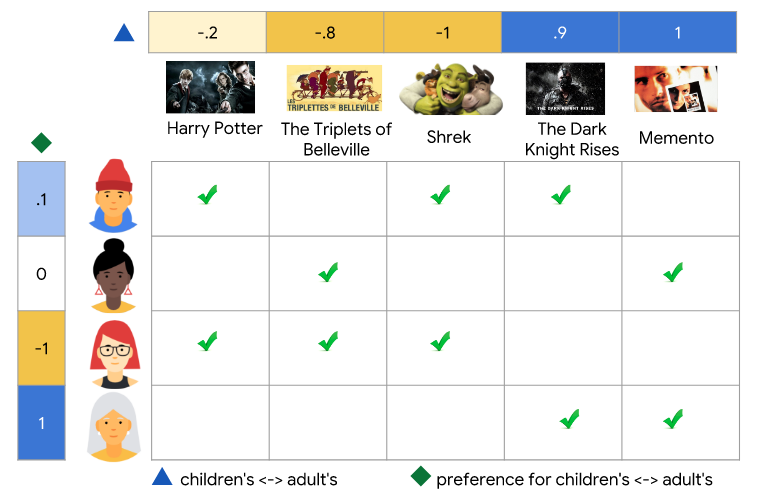
</div>

\
Since the utility matrix can become very large with order $O(M.N) where M is number of viewers and N is number of movies, processing it can become slow. Moreover, the matrix can be sparse and it can become inefficient to store it in its entirily. We make use of singular value decomposition to reduce the matrix reduce the dimensionality of the matrix and only keep the smaller set of significant latent factors which makes a close approximation of the full matrix.

In [130]:
#Instantiate a reader.
reader = Reader()

#load ratings file which contains users, movies and the ratings
ratings = pd.read_csv('/home/jupyter/recommendation_systems/movie_recommender/input/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [131]:
id_map = pd.read_csv('/home/jupyter/recommendation_systems/movie_recommender/input/links.csv')[['movieId', 'tmdbId']]

In [132]:
df_movies_metadata_small = pd.merge(df_movies_metadata,id_map,left_on = 'id',right_on = 'movieId')
df_movies_metadata_small.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,year,genres1,plot,director,top3_actors,top3_actors1,director1,soup,movieId,tmdbId
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995,"[Animation, Comedy, Family]",,John Lasseter,"[Tom Hanks, Tim Allen, Don Rickles]","[TomHanks, TimAllen, DonRickles]","[JohnLasseter, JohnLasseter, JohnLasseter]",jealousi toy boy friendship friend rivalri boy...,862,88224.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995,"[Adventure, Fantasy, Family]",Roll the dice and unleash the excitement! When...,Joe Johnston,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[RobinWilliams, JonathanHyde, KirstenDunst]","[JoeJohnston, JoeJohnston, JoeJohnston]",board gam disappear based on children's book n...,8844,42164.0
2,False,NaN,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995,"[Action, Crime, Drama]",A Los Angeles Crime Saga Obsessive master thie...,Michael Mann,"[Al Pacino, Robert De Niro, Val Kilmer]","[AlPacino, RobertDeNiro, ValKilmer]","[MichaelMann, MichaelMann, MichaelMann]",robberi detect bank obsess chase shoot thief h...,949,220.0
3,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,1995,"[Adventure, Action, Thriller]",No limits. No fears. No substitutes. James Bon...,Martin Campbell,"[Pierce Brosnan, Sean Bean, Izabella Scorupco]","[PierceBrosnan, SeanBean, IzabellaScorupco]","[MartinCampbell, MartinCampbell, MartinCampbell]",cuba falsely accus secret ident computer virus...,710,23449.0
4,False,NaN,98000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,1408,tt0112760,en,Cutthroat Island,"Morgan Adams and her slave, William Shaw, are ...",...,1995,"[Action, Adventure]",The Course Has Been Set. There Is No Turning B...,Renny Harlin,"[Geena Davis, Matthew Modine, Frank Langella]","[GeenaDavis, MatthewModine, FrankLangella]","[RennyHarlin, RennyHarlin, RennyHarlin]",exotic island treasur map ship scalp pirat Gee...,1408,9361.0


In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=0.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

In [147]:
predictions = algo.fit(trainset).test(testset)

In [205]:
ratings[ratings['userId'] == 1].head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [152]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=3.9519879413221553, details={'was_impossible': False})

In [153]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [154]:
df_movies_metadata.rename(columns={'movie_id':'id'},inplace=True)

In [183]:
id_map = pd.read_csv('/home/jupyter/recommendation_systems/movie_recommender/input/links.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(df_movies_metadata[['title', 'id']], on='id').set_index('title')

In [184]:
indices_map = id_map.set_index('id')

In [198]:
def hybrid(userId, title):
    idx= df_movies_metadata[df_movies_metadata['title'] == title].sort_values(by='popularity', ascending=False).index[0]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = df_movies_metadata.iloc[movie_indices][['title', 'top3_actors', 'director', 'genres1','year','id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies[['title','year','director','top3_actors', 'genres1']].head(10)

In [204]:
hybrid(2,'The Dark Knight') # For viewer id 2, recommend movies that are similar to the 'The Dark Knight'

,title,year,director,top3_actors,genres1
18448,Sherlock Holmes: A Game of Shadows,2011,Guy Ritchie,"[Robert Downey Jr., Jude Law, Jared Harris]","[Adventure, Action, Crime]"
10210,Batman Begins,2005,Christopher Nolan,"[Christian Bale, Michael Caine, Liam Neeson]","[Action, Crime, Drama]"
19981,"Batman: The Dark Knight Returns, Part 1",2012,Jay Oliva,"[Peter Weller, Ariel Winter, David Selby]","[Action, Animation]"
15682,Batman: Under the Red Hood,2010,Brandon Vietti,"[Bruce Greenwood, Jensen Ackles, Neil Patrick ...","[Action, Animation]"
43142,The Lego Batman Movie,2017,Chris McKay,"[Will Arnett, Zach Galifianakis, Michael Cera]","[Action, Animation, Comedy]"
18442,The Dark Knight Rises,2012,Christopher Nolan,"[Christian Bale, Michael Caine, Gary Oldman]","[Action, Crime, Drama]"
20435,"Batman: The Dark Knight Returns, Part 2",2013,Jay Oliva,"[Peter Weller, Ariel Winter, David Selby]","[Action, Animation]"
18225,Batman: Year One,2011,Lauren Montgomery,"[Ben McKenzie, Bryan Cranston, Eliza Dushku]","[Action, Adventure, Animation]"
14473,Law Abiding Citizen,2009,F. Gary Gray,"[Jamie Foxx, Gerard Butler, Colm Meaney]","[Drama, Crime, Thriller]"
22219,The Super Cops,1974,Gordon Parks,"[Ron Leibman, David Selby, Sheila Frazier]","[Drama, Comedy, Action]"


Now we have built a recommender that personalizes recommendation for each viewer based on their ratings of other movies and based on similarity of other viewers' ratings.

### References

Refering to the following work done on kaggle was very helpful
1. https://www.kaggle.com/code/rounakbanik/movie-recommender-systems/notebook
2. https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system